## Verification and Bias testing 
Choose one of the PREDICTANDS in the first cell and run entire cells to view the results.

*y_pred*: 25 member Ensemble Downscaled tasmean --> the 25 members are further feature reduced to one variable for verification and bias testing purpose

*y_true*: CERRA Tasmean for the given period

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'
year = 2016

In [2]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'Downscaled SEAS5'
TRUE = f'CERRA_{PREDICTAND}'

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [4]:
if year == 2016:

    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/sf_downscaling/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2m_0mm_dem_doy_hindcast.nc")    

else:
    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_0mm_dem_doy_2020.nc")    

y_pred

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 366, number: 25, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * number   (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x, number) float64 1GB ...

In [5]:
y_pred = y_pred - 273.15

In [6]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_2m_tasmin_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_2m_tasmax_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [7]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

In [8]:
y_true

<xarray.Dataset> Size: 23MB
Dimensions:            (x: 161, y: 96, time: 366)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31
Data variables:
    tasmean            (time, y, x) float32 23MB 13.33 13.16 ... -3.534 -3.587
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [9]:
y_pred

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 366, number: 25, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * number   (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x, number) float64 1GB 5.292 7.889 2.468 ... 3.79 4.118

In [10]:
tasmean = y_pred[PREDICTAND].mean(dim='number')
y_pred = tasmean.to_dataset(name=PREDICTAND)


In [11]:
y_pred

<xarray.Dataset> Size: 45MB
Dimensions:  (time: 366, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x) float64 45MB 5.722 5.548 5.333 ... -1.884 -2.079

In [12]:
def get_time_range(dataset):
    time_coord = dataset.time

    # Get the starting and ending years
    start_year = time_coord.min().dt.year.item()
    end_year = time_coord.max().dt.year.item()

    return str(start_year), str(end_year)

start_year, end_year = get_time_range(y_pred)
print("Starting year:", start_year)
print("Ending year:", end_year)


Starting year: 2016
Ending year: 2017


In [13]:
# align datasets and mask missing values in Insitu:CERRA predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')

In [14]:
y_true

<xarray.DataArray 'tasmean' (time: 366, y: 96, x: 161)> Size: 23MB
array([[[13.332031 , 13.155853 , 13.173889 , ..., 14.601959 ,
         14.769684 , 14.815216 ],
        [12.803009 , 12.633759 , 13.010864 , ..., 14.442078 ,
         14.594421 , 14.234802 ],
        [12.55719  , 12.670898 , 12.9935   , ..., 14.115356 ,
         13.569855 , 13.2482605],
        ...,
        [ 8.907623 ,  8.857544 ,  8.781403 , ...,  6.00412  ,
          6.1945496,  6.5510864],
        [ 8.923248 ,  8.952301 ,  8.816315 , ...,  6.927002 ,
          7.1152954,  7.2220764],
        [ 9.169678 ,  9.234161 ,  9.026245 , ...,  7.326782 ,
          7.235443 ,  7.062958 ]],

       [[ 9.733276 ,  9.647156 ,  9.518616 , ..., 13.416504 ,
         13.765808 , 13.781799 ],
        [ 9.657898 ,  9.382263 ,  9.417267 , ..., 12.304108 ,
         12.439575 , 11.629486 ],
        [ 9.689178 ,  9.606567 ,  9.290558 , ..., 11.810394 ,
         10.808746 , 10.554657 ],
...
        [ 3.7034607,  3.6688538,  3.5474854, ..., -8.575989 ,
         -8.335327 , -8.072998 ],
        [ 3.8312378,  3.8360596,  3.6514893, ..., -7.8843994,
         -7.4898376, -6.9812927],
        [ 4.070801 ,  4.148407 ,  3.8807373, ..., -6.680664 ,
         -6.5742493, -6.5910034]],

       [[11.63443  , 11.36319  , 10.93222  , ..., 11.799194 ,
         11.825195 , 11.452576 ],
        [11.163849 , 10.638275 , 10.240723 , ..., 10.801544 ,
         10.614563 ,  9.619659 ],
        [11.050812 , 10.553619 , 10.090912 , ...,  9.593964 ,
          8.640137 ,  8.03009  ],
        ...,
        [ 1.83078  ,  1.7143555,  1.4559021, ..., -6.2312927,
         -5.884674 , -5.363556 ],
        [ 1.5544434,  1.519989 ,  1.1804504, ..., -4.619507 ,
         -4.204773 , -3.913147 ],
        [ 1.4877625,  1.5236511,  1.1314087, ..., -3.5512695,
         -3.5336914, -3.586792 ]]], dtype=float32)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31

In [15]:
y_pred

<xarray.DataArray 'tasmean' (time: 366, y: 96, x: 161)> Size: 45MB
array([[[ 5.72220012,  5.54817108,  5.33262622, ..., 10.2938111 ,
         10.39135559, 10.27886856],
        [ 5.28200703,  4.99295936,  4.75590301, ...,  9.21878323,
          9.29403797,  8.54972779],
        [ 5.10667663,  4.95118582,  4.84083517, ...,  8.4720906 ,
          7.39554974,  6.93206079],
        ...,
        [ 2.15401048,  2.22340698,  2.20264133, ..., -0.25627598,
         -0.29719903,  0.09152585],
        [ 2.10076985,  2.24779585,  2.10956795, ...,  0.09134148,
          0.33064648,  0.5025595 ],
        [ 2.44532112,  2.39983157,  2.27049449, ...,  0.42575242,
          0.35656477,  0.2694563 ]],

       [[ 5.53569794,  5.20482535,  5.12168228, ...,  9.20638327,
          9.36948466,  9.343518  ],
        [ 5.12015925,  4.64806518,  4.82248919, ...,  8.14545283,
          8.09198796,  7.37494773],
        [ 4.88580333,  4.7336759 ,  4.48311256, ...,  7.33845691,
          6.36374217,  5.86192067],
...
        [ 0.39554144,  0.36027649,  0.27648037, ..., -3.02869681,
         -2.92550435, -2.41631142],
        [ 0.36926398,  0.48690832,  0.42198926, ..., -2.27708696,
         -2.03057822, -1.86591638],
        [ 0.61565984,  0.66843809,  0.5562901 , ..., -1.94151798,
         -2.02978201, -2.12725961]],

       [[ 3.77543034,  3.4760645 ,  3.29522722, ...,  8.36704289,
          8.5124166 ,  8.36130317],
        [ 3.34301058,  3.00354532,  2.89180825, ...,  7.32264206,
          7.33358489,  6.52403883],
        [ 3.3229953 ,  3.03200551,  2.90193264, ...,  6.46030076,
          5.54979157,  5.06390581],
        ...,
        [ 0.5813276 ,  0.63959121,  0.51642922, ..., -2.67336051,
         -2.6907816 , -2.27689801],
        [ 0.5988189 ,  0.55550821,  0.64525123, ..., -2.21267513,
         -2.03130852, -1.89218119],
        [ 0.89454341,  0.91400368,  0.71211787, ..., -1.84319012,
         -1.88394245, -2.07926395]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82

In [16]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [17]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [18]:
# compute daily anomalies
def anomalies(ds, timescale='time.dayofyear', standard=False):
        # group dataset by time scale
        groups = ds.groupby(timescale).groups

        # compute anomalies over time
        anomalies = {}
        for time, time_scale in groups.items():
            with warnings.catch_warnings():
                warnings.simplefilter('ignore', category=RuntimeWarning)
                # anomaly = (x(t) - mean(x, t))
                anomalies[time] = (ds.isel(time=time_scale) -
                                   ds.isel(time=time_scale).mean(dim='time'))

                # standardized anomaly = (x(t) - mean(x, t)) / std(x, t)
                if standard:
                    anomalies[time] /= ds.isel(time=time_scale).std(dim='time')

        # concatenate anomalies and sort chronologically
        anomalies = xr.concat(anomalies.values(), dim='time')
        anomalies = anomalies.sortby(anomalies.time)

        return anomalies

y_pred_anom = anomalies(y_pred, timescale='time.month')
y_true_anom = anomalies(y_true, timescale='time.month')

In [19]:
y_pred_anom

<xarray.DataArray 'tasmean' (time: 366, y: 96, x: 161)> Size: 45MB
array([[[-0.57239642, -0.38432111, -0.37864169, ...,  0.41809512,
          0.3916245 ,  0.39341574],
        [-0.6045413 , -0.4133682 , -0.5915173 , ...,  0.29689714,
          0.42640042,  0.43857165],
        [-0.60570211, -0.454098  , -0.42722036, ...,  0.31078762,
          0.1679002 ,  0.12622884],
        ...,
        [-0.06148005, -0.00158632,  0.00513197, ...,  0.10205531,
         -0.07109062,  0.01461759],
        [-0.11060159, -0.00173084, -0.04142488, ..., -0.20070959,
         -0.15532905, -0.1089272 ],
        [ 0.05128036, -0.08415312, -0.0587248 , ..., -0.2338565 ,
         -0.2421037 , -0.25226723]],

       [[-0.75889861, -0.72766684, -0.58958564, ..., -0.66933271,
         -0.63024642, -0.54193482],
        [-0.76638908, -0.75826239, -0.52493112, ..., -0.77643327,
         -0.7756496 , -0.73620841],
        [-0.8265754 , -0.67160792, -0.78494296, ..., -0.82284607,
         -0.86390737, -0.94391128],
...
        [-0.29007883, -0.34893254, -0.39869136, ..., -0.35942952,
         -0.38931369, -0.1698456 ],
        [-0.33324851, -0.25124366, -0.25858127, ..., -0.13115807,
         -0.02015767,  0.01615151],
        [-0.26034773, -0.32646071, -0.30956329, ..., -0.06175397,
         -0.1157447 , -0.1410364 ]],

       [[-0.63106044, -0.57413129, -0.50456878, ..., -0.80645426,
         -0.75276979, -0.78412188],
        [-0.57087099, -0.42979668, -0.50006259, ..., -0.71604955,
         -0.6140211 , -0.62110054],
        [-0.38127064, -0.46740741, -0.48961567, ..., -0.70495772,
         -0.63109064, -0.63983615],
        ...,
        [-0.10429268, -0.06961782, -0.15874251, ..., -0.00409322,
         -0.15459094, -0.03043219],
        [-0.10369359, -0.18264377, -0.03531929, ..., -0.06674623,
         -0.02088797, -0.0101133 ],
        [ 0.01853584, -0.08089512, -0.15373553, ...,  0.03657389,
          0.03009486, -0.09304074]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82

In [20]:
y_true_anom

<xarray.DataArray 'tasmean' (time: 366, y: 96, x: 161)> Size: 23MB
array([[[ 4.95211697e+00,  5.05277157e+00,  5.29033804e+00, ...,
          1.78967476e+00,  1.68302631e+00,  1.75264549e+00],
        [ 4.82168150e+00,  5.03281689e+00,  5.50331688e+00, ...,
          2.21046734e+00,  2.13318062e+00,  2.23656464e+00],
        [ 4.71373796e+00,  5.20194101e+00,  5.72712231e+00, ...,
          2.25159740e+00,  2.23502159e+00,  2.19015408e+00],
        ...,
        [ 5.98959446e+00,  5.96851110e+00,  5.96696949e+00, ...,
          3.09739852e+00,  3.13882017e+00,  3.11487031e+00],
        [ 6.05589962e+00,  6.06813812e+00,  6.06551600e+00, ...,
          3.12506104e+00,  2.99889278e+00,  2.87710142e+00],
        [ 6.12953138e+00,  6.12604809e+00,  6.11180401e+00, ...,
          2.83796549e+00,  2.65586710e+00,  2.47413778e+00]],

       [[ 1.35336208e+00,  1.54407406e+00,  1.63506460e+00, ...,
          6.04219437e-01,  6.79150581e-01,  7.19228745e-01],
        [ 1.67657042e+00,  1.78132153e+00,  1.90971947e+00, ...,
          7.24973679e-02, -2.16655731e-02, -3.68751526e-01],
        [ 1.84572649e+00,  2.13760996e+00,  2.02418041e+00, ...,
         -5.33647537e-02, -5.26086807e-01, -5.03449440e-01],
...
         -2.88959217e+00, -2.77527952e+00, -2.73268175e+00],
        [ 5.28213024e+00,  5.30914593e+00,  5.26633358e+00, ...,
         -2.76820612e+00, -2.59330511e+00, -2.28434038e+00],
        [ 5.39926434e+00,  5.43469810e+00,  5.36890030e+00, ...,
         -2.16680002e+00, -2.13059855e+00, -2.13792849e+00]],

       [[ 7.50196886e+00,  7.48863554e+00,  7.28117323e+00, ...,
          5.36829185e+00,  4.99221706e+00,  4.73193073e+00],
        [ 7.59767628e+00,  7.38432980e+00,  7.08379745e+00, ...,
          5.43875313e+00,  5.06985950e+00,  4.81584501e+00],
        [ 7.80166054e+00,  7.57296276e+00,  7.15210152e+00, ...,
          4.89366293e+00,  4.66390991e+00,  4.45739269e+00],
        ...,
        [ 3.33581543e+00,  3.25945163e+00,  3.11529636e+00, ...,
         -5.44896126e-01, -3.24626446e-01, -2.32396126e-02],
        [ 3.00533581e+00,  2.99307537e+00,  2.79529500e+00, ...,
          4.96686459e-01,  6.91759586e-01,  7.83805370e-01],
        [ 2.81622601e+00,  2.80994248e+00,  2.61957169e+00, ...,
          9.62594509e-01,  9.09959316e-01,  8.66282940e-01]]],
      dtype=float32)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B 2.0
  * time               (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31

### Coefficient of determination

In [21]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.95
R2 on daily anomalies: -0.06


### Coefficient of determination: Spatially

In [22]:
# iterate over the grid points
r2 = np.ones((2,  len(y_pred.y), len(y_pred.x)), dtype=np.float32) * np.nan
for i in range(len(y_pred.x)):
    for j in range(len(y_pred.y)):
        # get observed and predicted monthly mean temperature for current grid point
        point_true = y_true_mm.isel(x=i, y=j)
        point_pred = y_pred_mm.isel(x=i, y=j)

        # remove missing values
        mask = ((~np.isnan(point_true)) & (~np.isnan(point_pred)))
        point_true = point_true[mask].values
        point_pred = point_pred[mask].values
        if point_true.size < 1:
            continue
        
        # get anomalies for current grid point
        point_anom_true = y_true_anom.isel(x=i, y=j)
        point_anom_pred = y_pred_anom.isel(x=i, y=j)
        
        # remove missing values
        mask_anom = ((~np.isnan(point_anom_true)) & (~np.isnan(point_anom_pred)))
        point_anom_true = point_anom_true[mask_anom].values
        point_anom_pred = point_anom_pred[mask_anom].values

        # compute coefficient of determination
        r2[0, j, i] = r2_score(point_true, point_pred)
        r2[1, j, i] = r2_score(point_anom_true, point_anom_pred)

/tmp/ipykernel_5296/2899518242.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  grn = cm.get_cmap('Greens', 128)
/tmp/ipykernel_5296/2899518242.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  red = cm.get_cmap('Reds_r', 128)


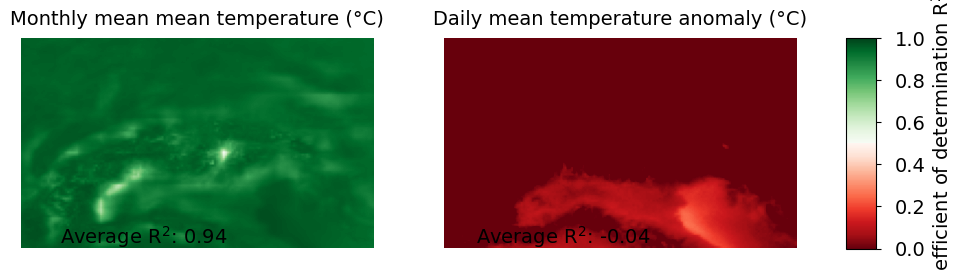

In [23]:
# define color map: red to green
grn = cm.get_cmap('Greens', 128)
red = cm.get_cmap('Reds_r', 128)
red2green = ListedColormap(np.vstack((red(np.linspace(0, 1, 128)),
                                      grn(np.linspace(0, 1, 128)))))

# plot coefficient of determination
vmin, vmax = 0, 1
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# monthly means
im0 = ax[0].imshow(r2[0, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[0].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[0, :])), fontsize=14, ha='right');
ax[0].set_axis_off()
ax[0].set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# daily anomalies
im1 = ax[1].imshow(r2[1, :], origin='lower', cmap=red2green, vmin=vmin, vmax=vmax)
ax[1].text(x=r2.shape[1] - 2, y=2, s='Average R$^2$: {:.2f}'.format(np.nanmean(r2[1, :])), fontsize=14, ha='right');
ax[1].set_axis_off()
ax[1].set_title('Daily {} anomaly (°C)'.format(NAMES[PREDICTAND]), fontsize=14, pad=10);

# add colorbar 
cbar_ax_bias = fig.add_axes([ax[1].get_position().x1 + 0.05, ax[1].get_position().y0,
                             0.03, ax[1].get_position().y1 - ax[1].get_position().y0])
cbar_bias = fig.colorbar(im0, cax=cbar_ax_bias)
cbar_bias.set_label(label='Coefficient of determination R$^2$', fontsize=14)
cbar_bias.ax.tick_params(labelsize=14, pad=10)

# save figure
fig.savefig('../Notebooks/Figures/{}_r2_spatial.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Bias

Calculate yearly average bias over entire reference period:

In [24]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('({}:{}) Yearly average bias of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, bias_yearly_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average bias of tasmean: 0.31°C


In [25]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('({}:{}) Yearly average MAE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, mae_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average MAE of tasmean: 1.44°C


In [26]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('({}:{}) Yearly average RMSE of {}: {:.2f}°C'.format(TRUE, PRED, PREDICTAND, rmse_avg.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average RMSE of tasmean: 1.71°C


In [27]:
# Pearson's correlation coefficient over reference period
correlations = []
for year in y_pred_yearly_avg.year:
    y_p = y_pred_yearly_avg.sel(year=year).values        
    y_t = y_true_yearly_avg.sel(year=year).values
    r, _ = stats.pearsonr(y_p[~np.isnan(y_p)], y_t[~np.isnan(y_t)])
    print('({:d}): {:.2f}'.format(year.item(), r))
    correlations.append(r)
print('Yearly average Pearson correlation coefficient for {}: {:.2f}'.format(PREDICTAND, np.asarray(r).mean()))

(2016): 0.99
(2017): 0.96
Yearly average Pearson correlation coefficient for tasmean: 0.96


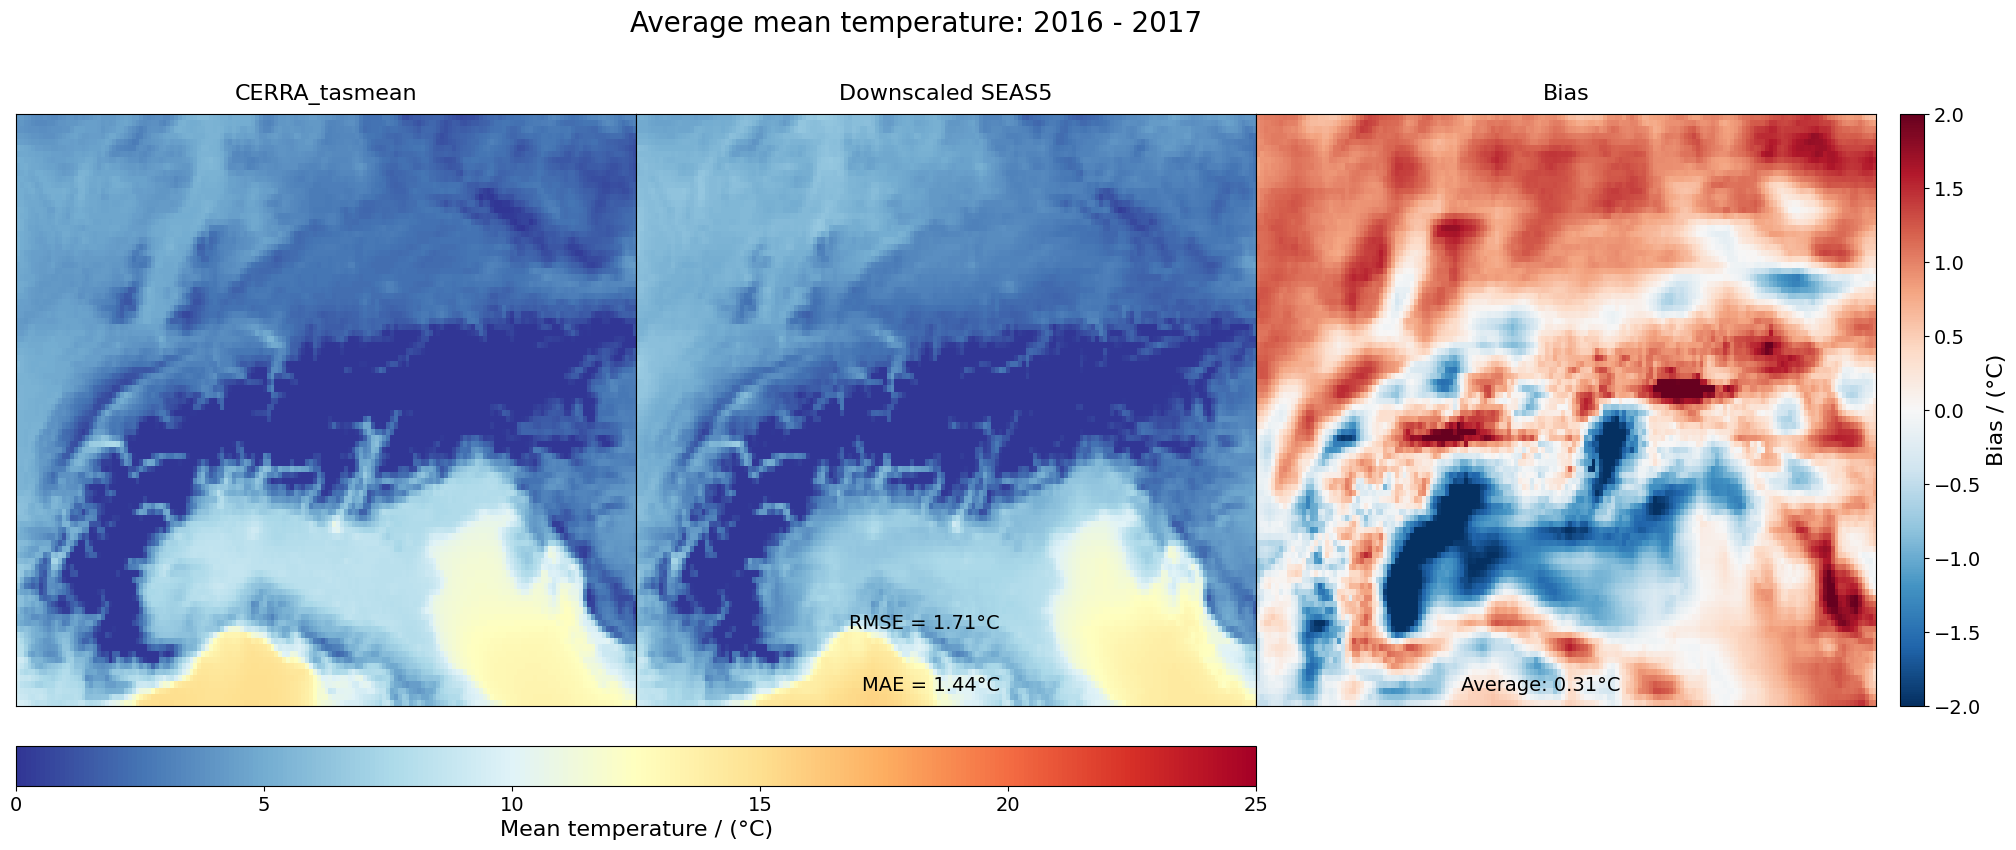

In [28]:
# plot average of observation, prediction, and bias
vmin, vmax = (-15, 15) if PREDICTAND == 'tasmin' else (0, 25)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_yearly_avg, y_pred_yearly_avg, bias_yearly_avg], axes):
    if ds is bias_yearly_avg:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='lower', cmap='RdYlBu_r', vmin=vmin, vmax=vmax)
        
# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax_bias = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                             0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar_bias = fig.colorbar(im2, cax=cbar_ax_bias)
cbar_bias.set_label(label='Bias / (°C)', fontsize=16)
cbar_bias.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_avg.mean().item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C'.format(rmse_avg.mean().item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_average_bias.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

### Seasonal bias

Calculate seasonal bias:

In [29]:
# group data by season: (DJF, MAM, JJA, SON)
y_true_snl = y_true.groupby('time.season').mean(dim='time')
y_pred_snl = y_pred.groupby('time.season').mean(dim='time')
bias_snl = y_pred_snl - y_true_snl

In [30]:
# print average bias per season: Insitu:CERRA
for season in bias_snl.season:
    print('({}:{}) Average bias of mean {} for season {}: {:.1f}°C'.format(TRUE, PRED, PREDICTAND, season.item(), bias_snl.sel(season=season).mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmean for season DJF: -0.8°C
(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmean for season JJA: -0.5°C
(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmean for season MAM: -1.1°C
(CERRA_tasmean:Downscaled SEAS5) Average bias of mean tasmean for season SON: -0.7°C


Plot seasonal differences, taken from the [xarray documentation](xarray.pydata.org/en/stable/examples/monthly-means.html).

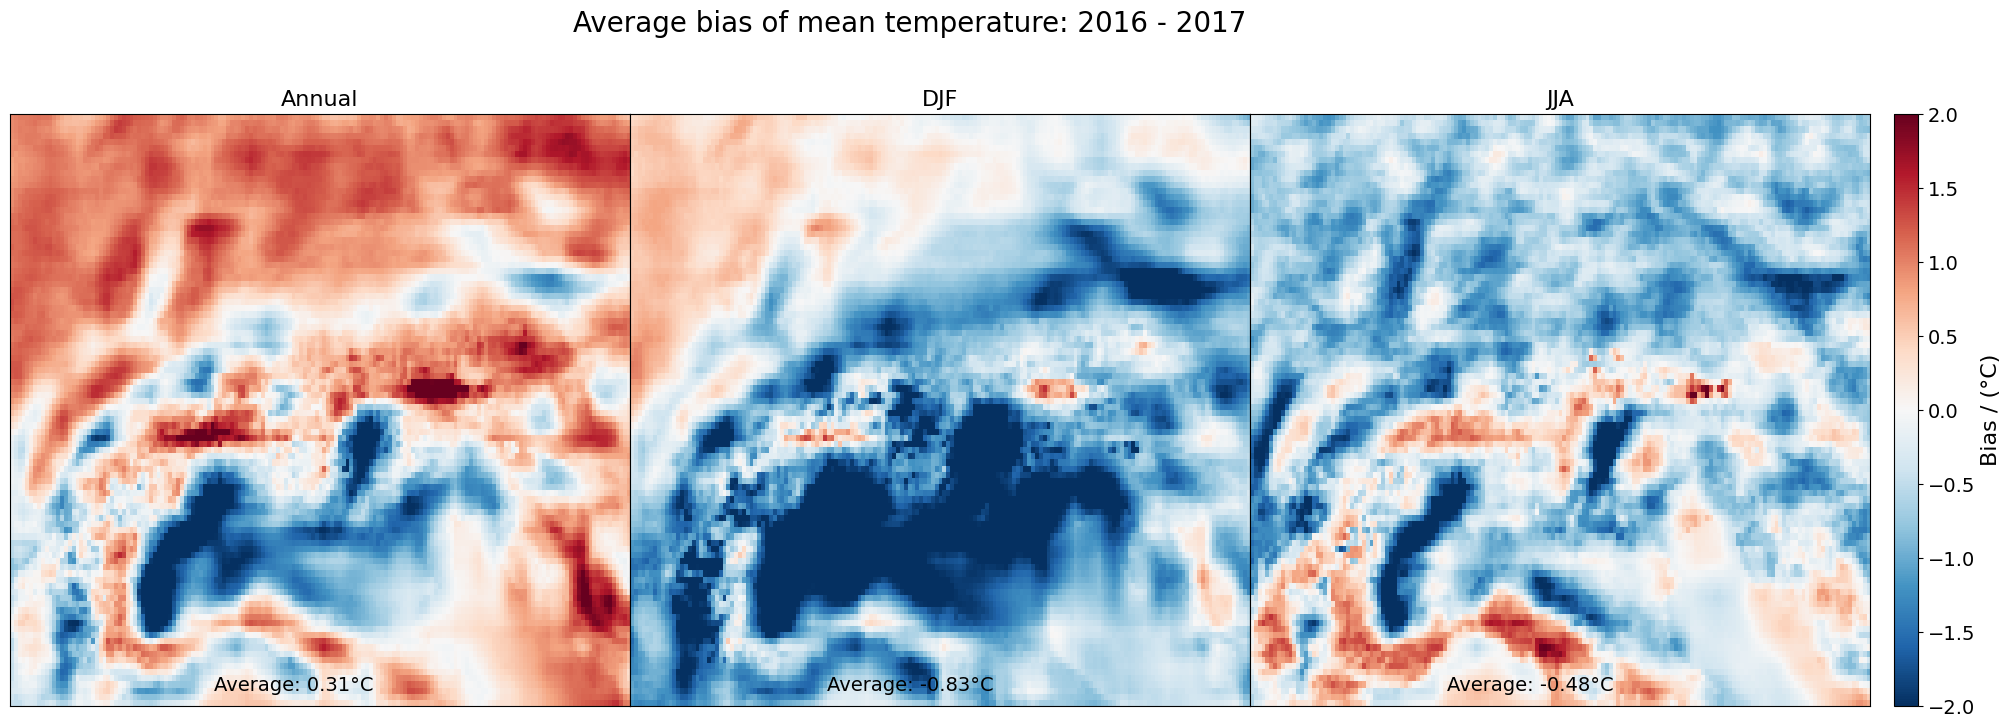

In [31]:
# plot seasonal differences
seasons = ('DJF', 'JJA')
fig, axes = plt.subplots(nrows=1, ncols=len(seasons) + 1, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot annual average bias
ds = bias_yearly_avg.mean(dim='year')
im = axes[0].imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
axes[0].set_title('Annual', fontsize=16);
axes[0].text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# plot seasonal average bias
for ax, season in zip(axes[1:], seasons):
    ds = bias_snl.sel(season=season)
    ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=16);
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar
cbar_ax_predictand = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                                   0.01, axes[0].get_position().y1 - axes[-1].get_position().y0])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand)
cbar_predictand.set_label(label='Bias / (°C)', fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

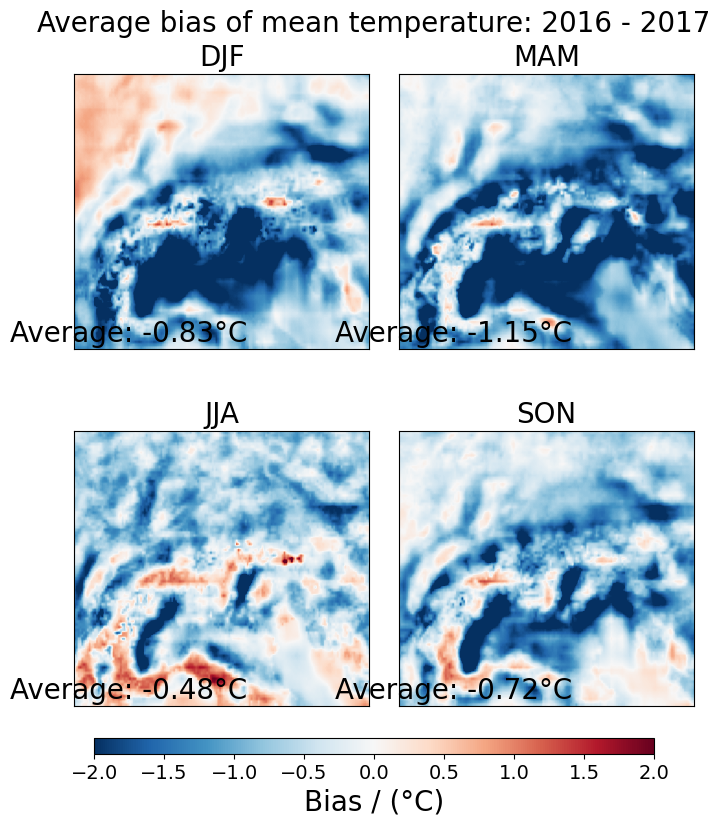

In [32]:
import matplotlib.pyplot as plt

# plot seasonal differences
seasons = ('DJF', 'MAM', 'JJA', 'SON')
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()

# plot seasonal average bias
for ax, season in zip(axes, seasons):
    ds = bias_snl.sel(season=season)
    im = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
    ax.set_title(season, fontsize=20)
    ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=20, ha='right')

# adjust axes
for ax in axes:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average bias of {}: {} - {}'.format(NAMES[PREDICTAND], start_year, end_year), fontsize=20)
fig.subplots_adjust(hspace=0.3, wspace=0.1, top=0.9)

# add colorbar at the bottom
cbar_ax_predictand = fig.add_axes([0.15, 0.05, 0.7, 0.02])
cbar_predictand = fig.colorbar(im, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='Bias / (°C)', fontsize=20)
cbar_predictand.ax.tick_params(labelsize=14)

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_seasonal.png'.format(PREDICTAND), dpi=300, bbox_inches='tight')

plt.show()


### Bias of extreme values

In [33]:
# extreme quantile of interest
quantile = 0.02 if PREDICTAND == 'tasmin' else 0.98

In [34]:
# calculate extreme quantile for each year
with warnings.catch_warnings():
    warnings.simplefilter('ignore', category=RuntimeWarning)
    y_pred_ex = y_pred.groupby('time.year').quantile(quantile, dim='time')
    y_true_ex = y_true.groupby('time.year').quantile(quantile, dim='time')

In [35]:
# calculate bias in extreme quantile for each year
bias_ex = y_pred_ex - y_true_ex

In [36]:
# bias of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average bias for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, bias_ex.mean().item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average bias for P98 of tasmean: -3.0°C


In [37]:
# mean absolute error in extreme quantile
mae_ex = np.abs(y_pred_ex - y_true_ex).mean()

In [38]:
# mae of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average MAE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, mae_ex.item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average MAE for P98 of tasmean: 3.0°C


In [39]:
# root mean squared error in extreme quantile
rmse_ex = np.sqrt(((y_pred_ex - y_true_ex) ** 2).mean())

In [40]:
# rmse of extreme quantile: Insitu:CERRA
print('({}:{}) Yearly average RMSE for P{:.0f} of {}: {:.1f}°C'.format(TRUE, PRED, quantile * 100, PREDICTAND, rmse_ex.item()))

(CERRA_tasmean:Downscaled SEAS5) Yearly average RMSE for P98 of tasmean: 3.3°C


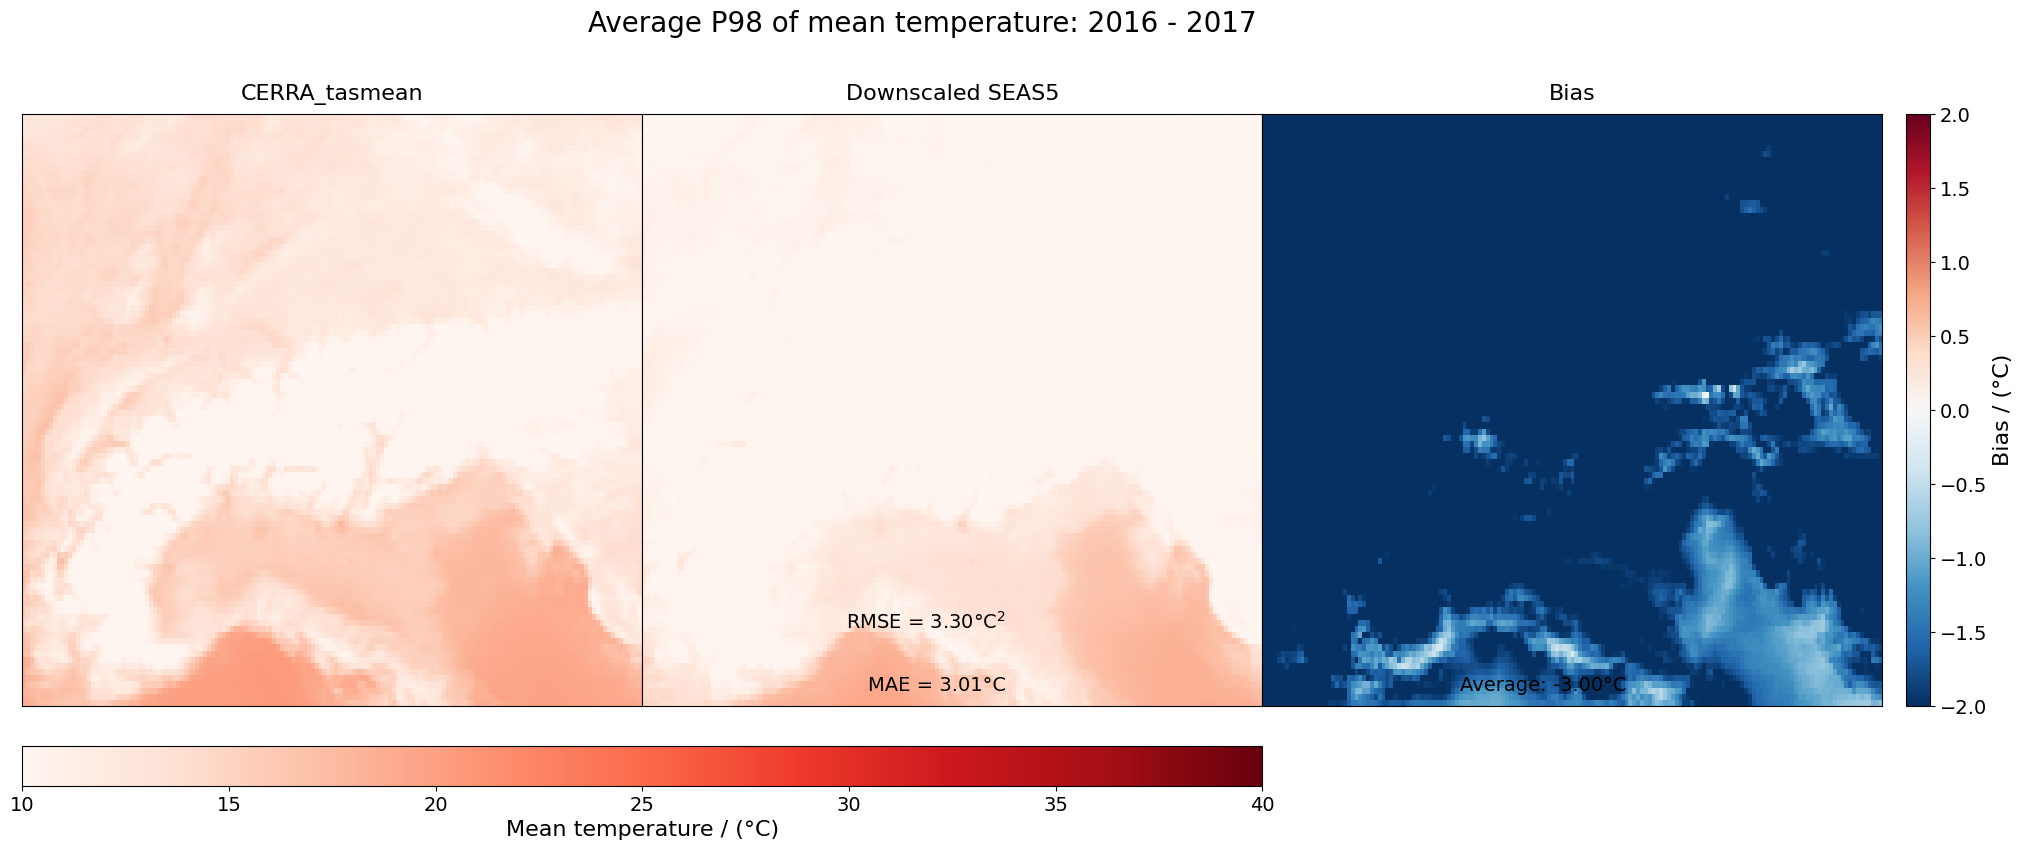

In [41]:
# plot extremes of observation, prediction, and bias
vmin, vmax = (-20, 0) if PREDICTAND == 'tasmin' else (10, 40)
fig, axes = plt.subplots(1, 3, figsize=(24, 8), sharex=True, sharey=True)
axes = axes.flatten()
for ds, ax in zip([y_true_ex, y_pred_ex, bias_ex], axes):
    if ds is bias_ex:
        ds = ds.mean(dim='year')
        im2 = ax.imshow(ds.values, origin='lower', cmap='RdBu_r', vmin=-2, vmax=2)
        ax.text(x=ds.shape[0] - 2, y=2, s='Average: {:.2f}°C'.format(ds.mean().item()), fontsize=14, ha='right')
    else:
        im1 = ax.imshow(ds.mean(dim='year').values, origin='lower', cmap='Blues_r' if PREDICTAND == 'tasmin' else 'Reds',
                        vmin=vmin, vmax=vmax)

# set titles
axes[0].set_title(TRUE, fontsize=16, pad=10);
axes[1].set_title(PRED, fontsize=16, pad=10);
axes[2].set_title('Bias', fontsize=16, pad=10);

# adjust axes
for ax in axes.flat:
    ax.axes.get_xaxis().set_ticklabels([])
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticklabels([])
    ax.axes.get_yaxis().set_ticks([])
    ax.axes.axis('tight')
    ax.set_xlabel('')
    ax.set_ylabel('')

# adjust figure
fig.suptitle('Average P{:.0f} of {}: {} - {}'.format(quantile * 100, NAMES[PREDICTAND], start_year, end_year), fontsize=20);
fig.subplots_adjust(hspace=0, wspace=0, top=0.85)

# add colorbar for bias
axes = axes.flatten()
cbar_ax = fig.add_axes([axes[-1].get_position().x1 + 0.01, axes[-1].get_position().y0,
                        0.01, axes[-1].get_position().y1 - axes[-1].get_position().y0])
cbar = fig.colorbar(im2, cax=cbar_ax)
cbar.set_label(label='Bias / (°C)', fontsize=16)
cbar.ax.tick_params(labelsize=14)

# add colorbar for predictand
cbar_ax_predictand = fig.add_axes([axes[0].get_position().x0, axes[0].get_position().y0 - 0.1,
                                   axes[-1].get_position().x0 - axes[0].get_position().x0,
                                   0.05])
cbar_predictand = fig.colorbar(im1, cax=cbar_ax_predictand, orientation='horizontal')
cbar_predictand.set_label(label='{} / (°C)'.format(NAMES[PREDICTAND].capitalize()), fontsize=16)
cbar_predictand.ax.tick_params(labelsize=14)

# add metrics: MAE and RMSE
axes[1].text(x=ds.shape[0] - 2, y=2, s='MAE = {:.2f}°C'.format(mae_ex.item()), fontsize=14, ha='right')
axes[1].text(x=ds.shape[0] - 2, y=12, s='RMSE = {:.2f}°C$^2$'.format(rmse_ex.item()), fontsize=14, ha='right')

# save figure
fig.savefig('../Notebooks/Figures/{}_bias_p{:.0f}.png'.format(PREDICTAND, quantile * 100), dpi=300, bbox_inches='tight')

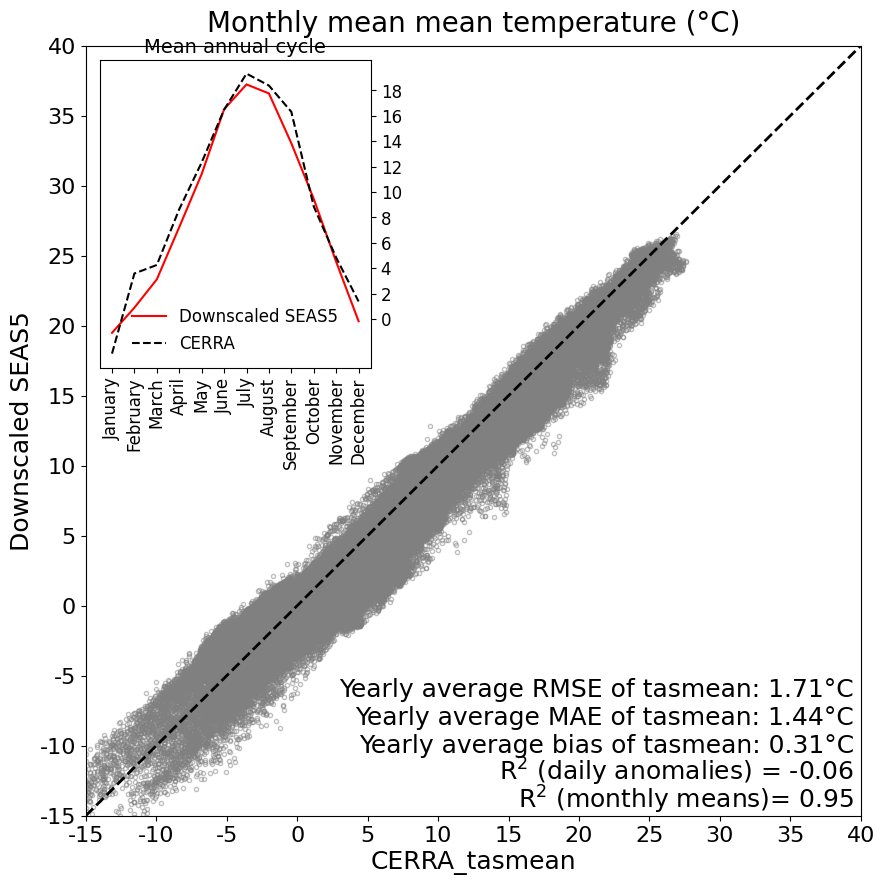

In [42]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3)

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)

ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA_tasmean', fontsize=18)
ax.set_ylabel(PRED, fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='-', color='r', label=PRED)
axins.plot(y_true_ac.values, ls='--', color='k', label='CERRA')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('mslp.png', dpi=300, bbox_inches='tight')


In [43]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax' or 'tasmean'
year = 2016

In [44]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'tasmean': 'mean temperature'}
# dataset names mapping
PRED = 'Downscaled SEAS5'
TRUE = f'CERRA_{PREDICTAND}'

### Imports

In [45]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

### Load datasets

In [46]:
if year == 2016:

    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2016.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/sf_downscaling/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2m_0mm_dem_doy_hindcast.nc")    

else:
    if PREDICTAND == 'tasmin':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmin/LGBMRegressor_tasmin_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmax':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmax/LGBMRegressor_tasmax_ztuvq_500_850_mslpt2m_0mm_dem_doy_2020.nc")
        
    if PREDICTAND == 'tasmean':
        y_pred = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/thesis_output/RESULTS/tasmean/LGBMRegressor_tasmean_ztuvq_500_850_mslpt2_0mm_dem_doy_2020.nc")    

y_pred

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 366, number: 25, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * number   (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x, number) float64 1GB ...

In [47]:
y_pred = y_pred - 273.15

In [48]:
# CERRA Data
if PREDICTAND == 'tasmin':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmin/CERRA_2m_tasmin_1985_2020.nc")
    
if PREDICTAND == 'tasmax':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmax/CERRA_2m_tasmax_1985_2020.nc")
    
if PREDICTAND == 'tasmean':
    y_true = xr.open_dataset("/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/hydroModelDownscale/CERRA/tasmean/CERRA_2m_temperature_1985_2020.nc")    


y_true

y_true = y_true.rename({'lon': "x"})
y_true = y_true.rename({'lat': "y"})
y_true

<xarray.Dataset> Size: 813MB
Dimensions:            (x: 161, y: 96, time: 13149)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 105kB 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, y, x) float32 813MB ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [49]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true - 273.15

# Spatially Aggregated Time Series of 2m-temperature variables

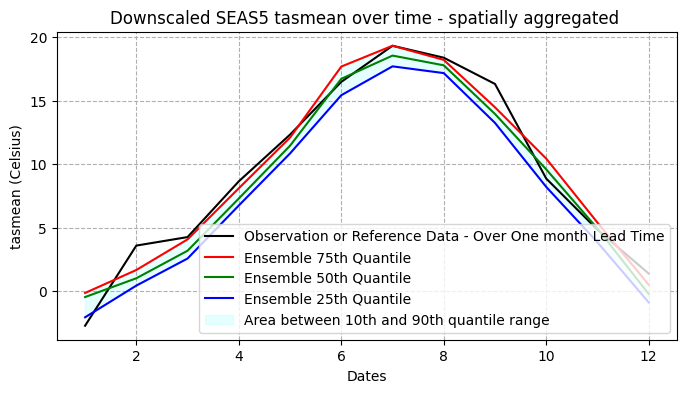

In [50]:
import numpy

weights = np.cos(np.deg2rad(y_pred.y))
weights.name = "weights"
ds_weighted = y_pred.weighted(weights)

data = ds_weighted.mean(dim=["y", "x"])
#SEAS5 Forecast Data Spatial Aggregation
#data = y_pred.mean(['y', 'x'])

data = data[list(data.data_vars)[0]]
data
variable = list(y_pred.data_vars)[0]
data = data.groupby('time.month').mean(keep_attrs=True)


#CERRA Reanalysis Data Spatial Aggregation
ref = y_true.mean(['y', 'x'])
ref = ref[list(ref.data_vars)[0]]
ref = ref.groupby('time.month').mean(keep_attrs=True)

ref


#Picking the Quantile for the Ensemble Members
data_90 = data.quantile(0.75, dim='number')
data_10 = data.quantile(0.25, dim='number')
data_50 = data.quantile(0.5, dim='number')

fig, ax = plt.subplots(1, 1, figsize = (8, 4))

colours = ['black','red','green','blue', 'cyan']
ax.plot(ref.month, ref[:], color=f'{colours[0]}', label=f'Observation or Reference Data - Over One month Lead Time')
ax.plot(data_90.month, data_90[:], color=f'{colours[1]}', label=f'Ensemble 75th Quantile')
ax.plot(data_50.month, data_50[:], color=f'{colours[2]}', label=f'Ensemble 50th Quantile')
ax.plot(data_10.month, data_10[:], color=f'{colours[3]}', label=f'Ensemble 25th Quantile')
ax.fill_between(ref.month, data_90[:], data_10[:], alpha=0.1, color=f'{colours[4]}', label=f'Area between 10th and 90th quantile range')

#ax.set_xlim(2020-01-01,2020-12-31)
ax.set_title(f'Downscaled SEAS5 {variable} over time - spatially aggregated ')
ax.set_ylabel(f'{variable} (Celsius)')
ax.set_xlabel('Dates')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)
ax.grid(linestyle='--')

fig.savefig(f'SEAS5_annual_{variable}.png')

In [51]:
import xskillscore as xs



In [52]:
y_pred

<xarray.Dataset> Size: 1GB
Dimensions:  (time: 366, number: 25, y: 96, x: 161)
Coordinates:
  * time     (time) datetime64[ns] 3kB 2016-02-01 2016-02-02 ... 2017-01-31
  * number   (number) int64 200B 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * y        (y) float64 768B 43.62 43.69 43.75 43.82 ... 49.8 49.86 49.93 50.0
  * x        (x) float64 1kB 5.084 5.151 5.218 5.285 ... 15.62 15.69 15.76 15.82
Data variables:
    tasmean  (time, y, x, number) float64 1GB 5.292 7.889 2.468 ... 3.79 4.118

In [53]:
y_true

<xarray.Dataset> Size: 23MB
Dimensions:            (x: 161, y: 96, time: 366)
Coordinates:
  * x                  (x) float64 1kB 5.084 5.151 5.218 ... 15.69 15.76 15.82
  * y                  (y) float64 768B 43.62 43.69 43.75 ... 49.86 49.93 50.0
    heightAboveGround  float64 8B ...
  * time               (time) datetime64[ns] 3kB 2016-02-01 ... 2017-01-31
Data variables:
    tasmean            (time, y, x) float32 23MB 13.33 13.16 ... -3.534 -3.587
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Fri Dec 08 06:52:58 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [54]:
ds = xs.crps_ensemble(y_true, y_pred, dim = ['time'], member_dim = 'number')

/tmp/ipykernel_5296/2964363251.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(projection=ccrs.PlateCarree())


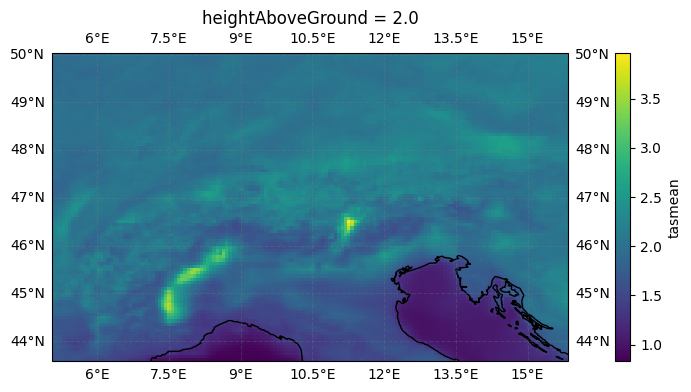

In [55]:
import cartopy.crs as ccrs

fig, ax = plt.subplots(1, 1, figsize = (12, 4))

ax = plt.subplot(projection=ccrs.PlateCarree())
ds.tasmean.plot.pcolormesh(x="x", y="y", ax=ax)
ax.coastlines()
# Create custom linestyle and color for gridlines
linestyle = '--'  # Double dashes for dotted lines
color = 'gray'     # Adjust transparency with alpha value (0: fully transparent, 1: opaque)
alpha = 0.25        # Set desired transparency level (between 0 and 1)

# Set gridlines properties
ax.gridlines(draw_labels=True, linestyle=linestyle, color=color, alpha=alpha)
plt.show()

In [56]:
ds1 = xs.crps_ensemble(y_true, y_pred, dim = ['x', 'y'], member_dim = 'number')

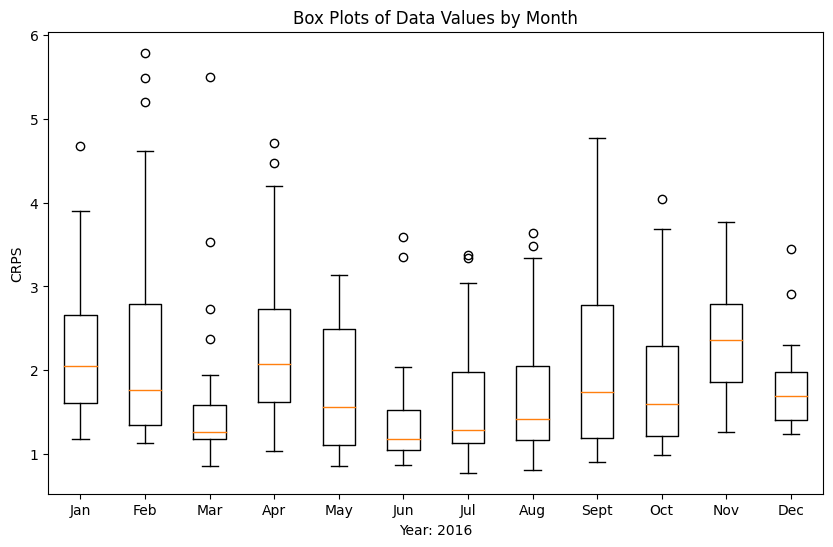

In [57]:
import matplotlib.pyplot as plt
import xarray as xr

# Get the month labels
month_labels = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sept", "Oct", "Nov", "Dec"]

grouped = ds1.tasmean.groupby('time.month')

monthly_values = []
for month, group in grouped:
    monthly_values.append(group.values)
# Create a box plot for each month
plt.figure(figsize=(10, 6))
plt.boxplot(monthly_values, labels=month_labels)
plt.xlabel('Month')
plt.ylabel('CRPS')
plt.xlabel(f"Year: {year}")
plt.title('Box Plots of Data Values by Month')
plt.grid(False)
plt.show()

Spread to Error Ratio

In [58]:
squared_diff = (y_true - y_pred)**2
mean_squared_diff = squared_diff.mean(dim="time")
rmse = np.sqrt(mean_squared_diff)
rmse = rmse.mean(dim="number")

std = y_pred.std(dim="number")
std = std.mean(dim="time")

spr = std / rmse

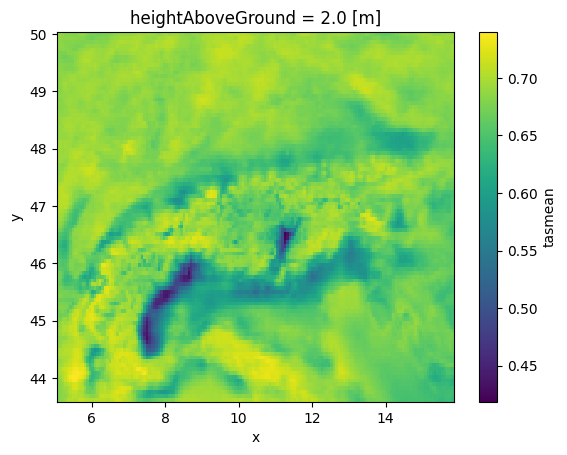

In [59]:
spr.tasmean.plot()

Ranked Probability Score

In [60]:
import xskillscore as xs

category_edges = np.array([.33, .66])
RPS = xs.rps(y_true, y_pred, category_edges, dim='time', member_dim='number')

In [61]:
RPS

<xarray.Dataset> Size: 126kB
Dimensions:                     (y: 96, x: 161)
Coordinates:
  * y                           (y) float64 768B 43.62 43.69 ... 49.93 50.0
  * x                           (x) float64 1kB 5.084 5.151 ... 15.76 15.82
    heightAboveGround           float64 8B 2.0
    observations_category_edge  <U45 180B '[-np.inf, 0.33), [0.33, 0.66), [0....
    forecasts_category_edge     <U45 180B '[-np.inf, 0.33), [0.33, 0.66), [0....
Data variables:
    tasmean                     (y, x) float64 124kB 0.02156 0.02861 ... 0.1452

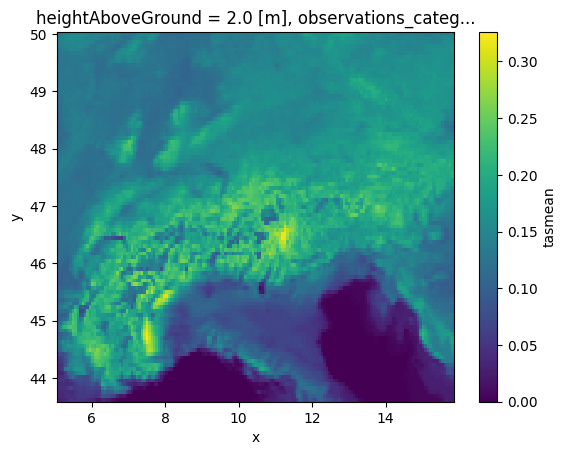

In [62]:
RPS.tasmean.plot()